In [1]:
import os
import logging
import time
import psycopg2

import pandas as pd
import numpy as np 
from sqlalchemy import create_engine

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
 

def connect_postgres():
    database = os.environ['POSTGRES_DB']
    user = os.environ['POSTGRES_USER']
    password = os.environ['POSTGRES_PASSWORD']
    host = os.environ['POSTGRES_SERVER']
    port = 5432

    exc, conn, engine = None, None, None

    for _ in range(5):
        try:
            conn = psycopg2.connect(
                database=database, user=user, password=password, host=host, port=port)
        except Exception as e:
            logging.warning("Error connecting to postgres, will retry in 3 sec: %s", e)
            time.sleep(3)
            exc = e
        else:
            logging.info("Connected...")
            logging.info("Everything goes well from Postgres, you're a fu*** pro...")
            
            engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                user, password, host, port, database
            ))
            break
    else:
        logging.error("Unable to connect to  %s DB", database)
        raise exc
    
    return [conn, engine]


In [2]:
[conn, engine] = connect_postgres()

INFO:root:Connected...
INFO:root:Everything goes well from Postgres, you're a fu*** pro...


In [67]:
df_iss = pd.read_sql("""
SELECT
	copytransaction.id, title_name, code, trans_copy_code_id, trans_tittle_code_id, trans_date_id as date_iss
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date, public.title
WHERE
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3845' AND
	trans_type_code IN ('ISS') AND
    trans_tittle_code_id = title.id AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code, id, title_name

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [86]:
df_ret = pd.read_sql("""
SELECT
    trans_copy_code_id, trans_tittle_code_id, title_name, code, trans_date_id as date_ret
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date, public.title
WHERE
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3845' AND
	trans_type_code IN ('RET') AND
    trans_tittle_code_id = title.id AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code, copy.id, title_name

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [81]:
df_iss = df_iss.reset_index(drop=True)
df_iss

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss
0,451025,"Mitos, leyendas tradiciones y folclor del lago...",199016624,87043,29956,19970421
1,5793416,Embarazo y maternidad en la adolescente,199016624,167070,125558,19970331
2,5717576,Innovación empresarial,199016624,172750,129871,19990302
3,5784442,Innovación empresarial,199016624,172750,129871,19991004
4,363282,Innovación empresarial,199016624,172750,129871,19991108
...,...,...,...,...,...,...
50185,8206381,Mecánica de materiales,201831023,872023,885431,20160118
50186,8323084,Mecánica de materiales,201831023,872023,885431,20160118
50187,8108942,Mecánica de materiales,201831023,872023,885431,20160211
50188,8164199,Mecánica de materiales,201831023,872023,885431,20160211


In [82]:
df_ret = df_ret.reset_index(drop=True)
df_ret

,trans_copy_code_id,trans_tittle_code_id,title_name,code,date_ret
0,16331,10188,Competitive strategy,199120033,19990318
1,131785,99376,Biología general,199120033,19990526
2,184745,138918,Colombia: Analisis al futuro,199120033,19971114
3,185454,139509,Investigación de operaciones en la ciencia adm...,199120033,19971023
4,185457,139509,Investigación de operaciones en la ciencia adm...,199120033,19970919
...,...,...,...,...,...
45085,706973,705983,Precálculo,201830743,20180209
45086,916536,928536,The purge,201830957,20180207
45087,804796,823917,Game of thrones,201830990,20180224
45088,873790,889459,The imitation game [videograbación],201830990,20180220


In [83]:
df_iss = df_iss.astype({col: 'int32' for col in df_iss.select_dtypes('int64').columns})
df_iss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50190 entries, 0 to 50189
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    50190 non-null  int32 
 1   title_name            50190 non-null  object
 2   code                  50190 non-null  int32 
 3   trans_copy_code_id    50190 non-null  int32 
 4   trans_tittle_code_id  50190 non-null  int32 
 5   date_iss              50190 non-null  int32 
dtypes: int32(5), object(1)
memory usage: 1.3+ MB


In [87]:
df_ret = df_ret.astype({col: 'int32' for col in df_ret.select_dtypes('int64').columns})
df_ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50487 entries, 0 to 50486
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   trans_copy_code_id    50487 non-null  int32 
 1   trans_tittle_code_id  50487 non-null  int32 
 2   title_name            50487 non-null  object
 3   code                  50487 non-null  int32 
 4   date_ret              50487 non-null  int32 
dtypes: int32(4), object(1)
memory usage: 1.2+ MB


In [90]:
df = df_iss.merge(df_ret, how='left', on=['code','trans_copy_code_id', 'trans_tittle_code_id', 'title_name'])
df['diff'] = df['date_ret'] - df['date_iss']
df = df[df['diff'] >= 0]
df = df.sort_values(
    ['trans_tittle_code_id', 'diff']
)
df

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss,date_ret,diff
9229,318766,Immanuel Kant,199716759,10,7,19991004,19991004.0,0.0
1290,29254,Convenios internacionales del trabajo ratifica...,199504417,219819,20,19990211,19990218.0,7.0
2955,21337,Convenios internacionales del trabajo ratifica...,199513368,21,20,19990210,19990226.0,16.0
3073,598276,La estructura de las encuestas por muestreo,199516001,23,23,19971110,19971110.0,0.0
7372,6022270,La estructura de las encuestas por muestreo,199711359,23,23,20020627,20020627.0,0.0
...,...,...,...,...,...,...,...,...
80225,9171410,Código de Comercio,201646936,916303,932280,20180309,20180309.0,0.0
80228,9206216,Código de Comercio,201646936,916303,932280,20180316,20180316.0,0.0
80020,9171408,Código de Comercio,201640035,916305,932280,20180309,20180316.0,7.0
80226,9171410,Código de Comercio,201646936,916303,932280,20180309,20180316.0,7.0


In [91]:
df.columns

Index(['id', 'title_name', 'code', 'trans_copy_code_id',
       'trans_tittle_code_id', 'date_iss', 'date_ret', 'diff'],
      dtype='object')

In [92]:
df['ISS'] = pd.to_datetime(df['date_iss'].astype(str), format='%Y%m%d') 
df['RET'] = pd.to_datetime(df['date_ret'].astype(str), format='%Y%m%d')
df['trans_copy_code_id'] = df['trans_copy_code_id'].astype(str)
df['trans_tittle_code_id'] = df['trans_tittle_code_id'].astype(str)
df['duration'] = df['RET'] - df['ISS'] + pd.Timedelta(days=1)
df['duration'] = df['duration'].dt.days
df

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss,date_ret,diff,ISS,RET,duration
9229,318766,Immanuel Kant,199716759,10,7,19991004,19991004.0,0.0,1999-10-04,1999-10-04,1
1290,29254,Convenios internacionales del trabajo ratifica...,199504417,219819,20,19990211,19990218.0,7.0,1999-02-11,1999-02-18,8
2955,21337,Convenios internacionales del trabajo ratifica...,199513368,21,20,19990210,19990226.0,16.0,1999-02-10,1999-02-26,17
3073,598276,La estructura de las encuestas por muestreo,199516001,23,23,19971110,19971110.0,0.0,1997-11-10,1997-11-10,1
7372,6022270,La estructura de las encuestas por muestreo,199711359,23,23,20020627,20020627.0,0.0,2002-06-27,2002-06-27,1
...,...,...,...,...,...,...,...,...,...,...,...
80225,9171410,Código de Comercio,201646936,916303,932280,20180309,20180309.0,0.0,2018-03-09,2018-03-09,1
80228,9206216,Código de Comercio,201646936,916303,932280,20180316,20180316.0,0.0,2018-03-16,2018-03-16,1
80020,9171408,Código de Comercio,201640035,916305,932280,20180309,20180316.0,7.0,2018-03-09,2018-03-16,8
80226,9171410,Código de Comercio,201646936,916303,932280,20180309,20180316.0,7.0,2018-03-09,2018-03-16,8


In [93]:
df.describe()

,id,code,date_iss,date_ret,diff,duration
count,6.516600e+04,6.516600e+04,6.516600e+04,6.516600e+04,65166.000000,65166.000000
mean,3.808469e+06,2.004536e+08,2.006728e+07,2.006836e+07,1083.967284,42.661679
std,2.360692e+06,5.754849e+05,5.010630e+04,5.019089e+04,4859.274837,168.120984
min,1.101000e+03,1.990166e+08,1.997033e+07,1.997033e+07,0.000000,1.000000
25%,1.855228e+06,2.001222e+08,2.003112e+07,2.003122e+07,0.000000,1.000000
50%,3.512524e+06,2.003327e+08,2.007022e+07,2.007033e+07,4.000000,4.000000
75%,5.589232e+06,2.008407e+08,2.010091e+07,2.010093e+07,89.000000,22.000000
max,9.219880e+06,2.018313e+08,2.018032e+07,2.018032e+07,150078.000000,5489.000000


In [94]:
df[df['duration'] <= 100].sort_values('duration')

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss,date_ret,diff,ISS,RET,duration
9229,318766,Immanuel Kant,199716759,10,7,19991004,19991004.0,0.0,1999-10-04,1999-10-04,1
49195,3549830,Estadística y muestreo,200623372,558876,549839,20071002,20071002.0,0.0,2007-10-02,2007-10-02,1
47029,3132270,Estadística y muestreo,200522336,558876,549839,20061204,20061204.0,0.0,2006-12-04,2006-12-04,1
46736,3075944,Estadística y muestreo,200522153,558876,549839,20061101,20061101.0,0.0,2006-11-01,2006-11-01,1
45810,2847869,Estadística y muestreo,200438379,558876,549839,20060511,20060511.0,0.0,2006-05-11,2006-05-11,1
...,...,...,...,...,...,...,...,...,...,...,...
65321,4868414,Matemáticas aplicadas a la administración y a ...,201038514,716233,666180,20101102,20110209.0,9107.0,2010-11-02,2011-02-09,100
61903,8424316,Los bonos como instrumento de financiamiento y...,200933550,515397,483673,20160405,20160713.0,308.0,2016-04-05,2016-07-13,100
62851,4495639,La administración de organizaciones,200934716,23549,14578,20090901,20091209.0,308.0,2009-09-01,2009-12-09,100
42081,4198120,Formulación del plan estratégico para la empre...,200342230,708287,719247,20090121,20090430.0,309.0,2009-01-21,2009-04-30,100


In [95]:
df = df[df['duration'] <= 100].sort_values('duration')

In [96]:
df_titles = df[['trans_tittle_code_id', 'title_name']]
df_titles = df_titles.set_index('trans_tittle_code_id')
df_titles

,title_name
trans_tittle_code_id,
7,Immanuel Kant
549839,Estadística y muestreo
549839,Estadística y muestreo
549839,Estadística y muestreo
549839,Estadística y muestreo
...,...
666180,Matemáticas aplicadas a la administración y a ...
483673,Los bonos como instrumento de financiamiento y...
14578,La administración de organizaciones


In [97]:
df_new = df.drop(['code', 'trans_copy_code_id', 'date_iss', 'id', 'date_ret', 'diff', 'ISS', 'RET'], axis=1)
df_new = df_new.groupby(['trans_tittle_code_id'])['duration'].agg(
    borrow_days='sum',
    borrow_numbers='count',
).sort_values(
    ['borrow_days', 'borrow_numbers']
).reset_index()
df_new['score'] = df_new['borrow_days'] * df_new['borrow_numbers']
df_new = df_new.set_index('trans_tittle_code_id')
# df_new = df_new.loc[(df_new['borrow_days']  <= 10950)] # past 30 years
df_new

,borrow_days,borrow_numbers,score
trans_tittle_code_id,,,
100429,1,1,1
100584,1,1,1
100693,1,1,1
101125,1,1,1
101381,1,1,1
...,...,...,...
624467,4517,219,989223
719247,4893,185,905205
846795,5493,203,1115079


In [98]:
df_new.describe()

,borrow_days,borrow_numbers,score
count,12748.000000,12748.000000,1.274800e+04
mean,59.153279,4.692815,3.099925e+03
std,213.333929,15.545309,4.116691e+04
min,1.000000,1.000000,1.000000e+00
25%,2.000000,1.000000,3.000000e+00
50%,15.000000,1.000000,1.700000e+01
75%,43.000000,3.000000,9.000000e+01
max,5999.000000,461.000000,1.820950e+06


In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

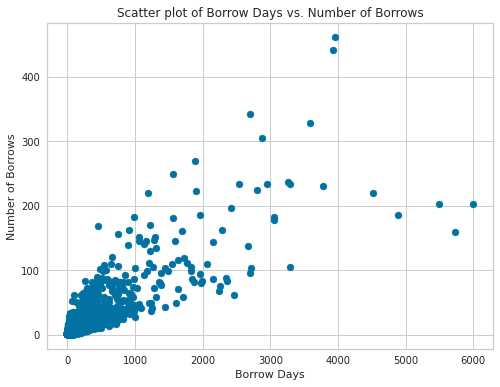

In [100]:
plt.figure(figsize=(8,6))
plt.scatter(df_new.borrow_days, df_new.borrow_numbers)
plt.xlabel('Borrow Days')
plt.ylabel('Number of Borrows')
plt.title('Scatter plot of Borrow Days vs. Number of Borrows')
plt.show()

In [101]:
# Import the sklearn function
from sklearn.preprocessing import StandardScaler

columns = df_new.columns
data_to_standardize = df_new[columns]
scaler = StandardScaler().fit(data_to_standardize)

# Standardize the columns.
standardized_data = df_new.copy()
standardized_columns = scaler.transform(data_to_standardize)
standardized_data[columns] = standardized_columns

standardized_data

,borrow_days,borrow_numbers,score
trans_tittle_code_id,,,
100429,-0.272603,-0.237561,-0.075280
100584,-0.272603,-0.237561,-0.075280
100693,-0.272603,-0.237561,-0.075280
101125,-0.272603,-0.237561,-0.075280
101381,-0.272603,-0.237561,-0.075280
...,...,...,...
624467,20.896918,13.786512,23.955208
719247,22.659482,11.599271,21.914216
846795,25.472084,12.757222,27.012541


In [102]:
standardized_data.describe()

,borrow_days,borrow_numbers,score
count,1.274800e+04,1.274800e+04,1.274800e+04
mean,1.783603e-17,1.783603e-17,-1.783603e-17
std,1.000039e+00,1.000039e+00,1.000039e+00
min,-2.726034e-01,-2.375610e-01,-7.528005e-02
25%,-2.679158e-01,-2.375610e-01,-7.523146e-02
50%,-2.069760e-01,-2.375610e-01,-7.489137e-02
75%,-7.572125e-02,-1.088998e-01,-7.311803e-02
max,2.784405e+01,2.935452e+01,4.415978e+01


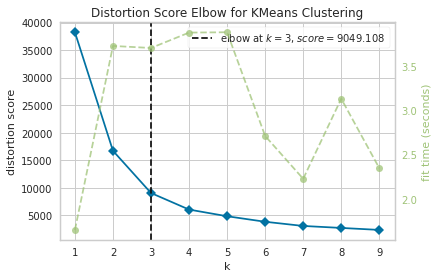

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [103]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(init='k-means++', random_state=540)
visualizer = KElbowVisualizer(km, k=(1,10))
 
visualizer.fit(standardized_data)
visualizer.show()

In [104]:
# Train a Kmeans instance
n_clusters = visualizer.elbow_value_

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=540)
kmeans.fit(standardized_data)
clusters = kmeans.predict(standardized_data)
df_new['cluster'] = clusters


df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('int64').columns})
df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('float64').columns})
df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('bool').columns})

df_new

,borrow_days,borrow_numbers,score,cluster
trans_tittle_code_id,,,,
100429,1,1,1,0
100584,1,1,1,0
100693,1,1,1,0
101125,1,1,1,0
101381,1,1,1,0
...,...,...,...,...
624467,4517,219,989223,1
719247,4893,185,905205,1
846795,5493,203,1115079,1


In [105]:
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

pca = PCA(n_components=2)

reduced_X = pd.DataFrame(pca.fit_transform(standardized_data), columns=["PC1", "PC2"])
reduced_X

,PC1,PC2
0,-0.338690,0.143368
1,-0.338690,0.143368
2,-0.338690,0.143368
3,-0.338690,0.143368
4,-0.338690,0.143368
...,...,...
12743,33.832863,5.866625
12744,32.417785,4.550529
12745,37.642687,7.186262
12746,33.776013,4.002475


In [106]:
reduced_X['cluster'] = clusters
reduced_X

,PC1,PC2,cluster
0,-0.338690,0.143368,0
1,-0.338690,0.143368,0
2,-0.338690,0.143368,0
3,-0.338690,0.143368,0
4,-0.338690,0.143368,0
...,...,...,...
12743,33.832863,5.866625,1
12744,32.417785,4.550529,1
12745,37.642687,7.186262,1
12746,33.776013,4.002475,1


/opt/app/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


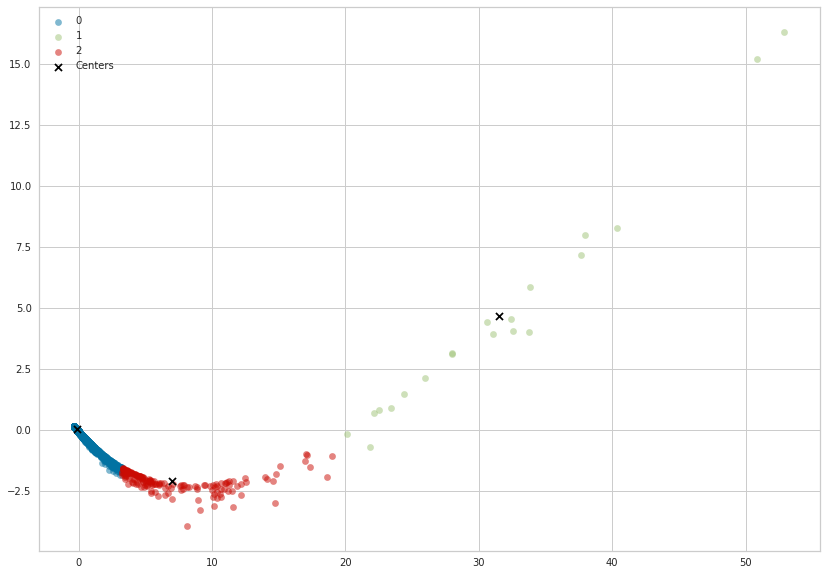

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

reduced_centers = pca.transform(kmeans.cluster_centers_)

for cluster in range(0, n_clusters):
    plt.scatter(
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC1'],
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC2'], 
        label=cluster, alpha=0.5, s=40
    )

plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], marker='x', label='Centers', c="black", s=50)
plt.legend()
plt.show()

In [108]:
number_clusters = df_new['cluster'].value_counts()

In [113]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12748 entries, 100429 to 658627
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   borrow_days     12748 non-null  int32
 1   borrow_numbers  12748 non-null  int32
 2   score           12748 non-null  int32
 3   cluster         12748 non-null  int32
dtypes: int32(4)
memory usage: 814.8+ KB


In [114]:
df_final = pd.merge(
    df_new, df_titles, on=['trans_tittle_code_id']
).drop_duplicates()
df_final

,borrow_days,borrow_numbers,score,cluster,title_name
trans_tittle_code_id,,,,,
100429,1,1,1,0,Agua y salud humana
100584,1,1,1,0,Derecho administrativo disciplinario
100693,1,1,1,0,Modelos para proporcionar amplios servicios de...
101125,1,1,1,0,Museo de la Caña de Azúcar
101381,1,1,1,0,Las estrategias de ruptura
...,...,...,...,...,...
624467,4517,219,989223,1,"Edipo, el hijo de la fortuna [Videograbación]"
719247,4893,185,905205,1,Formulación del plan estratégico para la empre...
846795,5493,203,1115079,1,Kindle paperwhite [lector de libros electrónicos]
